# Projet P3
## HeadlinesMachineLearningModel
Ce notebook retrace les différentes étapes de création des modèles de machines learning avec le jeu de données des titres d'articles financiers

`Auteur` : Romain Capocasale (INF3dlm-a)

`Date` : 01.10.2019

`Version de python` : 3.7.1

# 1. Importation

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import sys
import csv
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import pickle
from gensim.sklearn_api import D2VTransformer
from gensim.utils import simple_preprocess
from joblib import dump, load
import seaborn as sns
import random

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from tools.TextProcessor import TextProcessor

np.random.seed(42)# to make this notebook's output stable across runs

# 2. Chragement du jeu de données

In [16]:
dataset = pd.read_json('dataset/headlines_dataset/financialData.json')

# 3. Analyse du jeu de données

In [17]:
dataset.head()

,title,sentiment
0,watching for bounce tomorrow,0.366
1,record number of passengers served in 2015,0.638
2,out $NFLX -.35,-0.494
3,Looking for a strong bounce Lunchtime rally co...,0.460
4,Very intrigued with the technology and growth ...,0.403


In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
title        2866 non-null object
sentiment    2866 non-null float64
dtypes: float64(1), object(1)
memory usage: 44.9+ KB


In [19]:
dataset.describe()

,sentiment
count,2866.000000
mean,0.079841
std,0.391033
min,-1.000000
25%,-0.285000
50%,0.206000
75%,0.387000
max,1.000000


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, entre -1 pour negatif et 1 pour positif
    - title : la phrase en question

## 3.1 Répartition des classes

In [20]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 2866
Number of positive data : 1756 (61.27%)
Number of negative data : 1045 (36.462%)
Number of neutral data : 65 (2.268%)
Ratio positive/negative : 1.68


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018FC5792508>]],
      dtype=object)

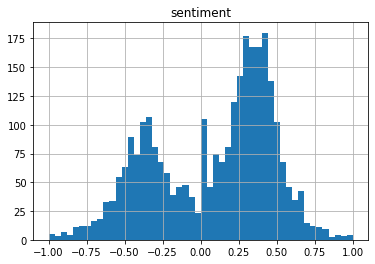

In [21]:
dataset.hist(bins=50)

On remarque qu'il y a plus de phrase avec un sentiment positif que négatif. On remarque également sur le graphe 2 pics, un pour les sentiments négatifs aux alentours de -0.40 et un pour les sentiment positif vers 0.40.

## 3.2 Nombre de mot moyen par phrase

In [22]:
def average_word_by_sentence(sentences):
    '''Compute the average of word in a sentence
    sentence -- list of sentences
    return -- average number of word by sentence
    '''
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [23]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 7.515


Text(0, 0.5, 'Number of sentence')

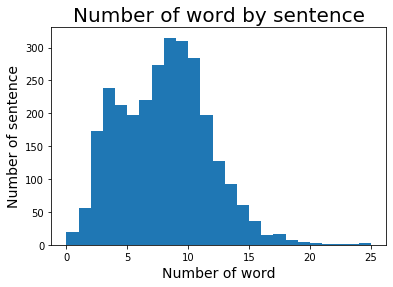

In [24]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **7.515** et on peut voir sur le graphe la répartition du nombre de mot par phrase.

# 4. Séparation des observation et des étiquettes

In [25]:
X = dataset['title']
y = dataset['sentiment']

## 4.1 Séparation du jeu d'entrainement et jeu de test 
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 5. Definition des méthode de calcul de score
La méthode print_scores() permet de calculer la RMSE, la MAE et la précision à partir des vrai étiquettes et des étiquettes prédites. Il est également possible d'indiquer le seuil désiré, le seuil permet de definir pour une prédiction si elle doit considéré come positive ou négative. La méthode regression_score_to_classification() permet de transformer les étiquettes du format régression au format classification. Les étiquettes de -1 à seuil sont mise à 0 et celles de seuil à 1 sont mise à 1.

In [61]:
def remove_near_zero_values(y_test, y_pred, threshold):
    '''As the classifier is here binary, on only keep the values between -1 and 0 not included and between 1 and 0 not included. 
    You must therefore delete the values at zero.Put in a list the indices of the values which are 0 and remove them from the 2 lists.
        
    y_test -- list of real value
    y_pred -- list of predicted value
    thrshold -- seuil
    
    return -- a tuple which contain y_test and y_pred without 0 values
    '''
    index_to_remove = []
    i = 0
    for test, pred in zip(y_test, y_pred):
        if test == threshold or pred == threshold:
            index_to_remove.append(i)
        i+=1
    y_test = [i for j, i in enumerate(y_test) if j not in index_to_remove]
    y_pred = [i for j, i in enumerate(y_pred) if j not in index_to_remove]
    return (y_test, y_pred)

def regression_score_to_classification(labels, threshold):
    '''Set to 0 regression prediction between -1 and thresold, set to 1 regression preiction between thresold and 1
    Allow to pass from regression prediction to classification prediction
    
    labels -- list of regression score
    thresold -- thresold
    
    return -- list of labels either 0 or 1
    '''
    
    y_clf = []
    for i, y in enumerate(labels):
        if y <= threshold:
            y_clf.append(0)
        elif y > threshold:
            y_clf.append(1)
    return np.array(y_clf)
        

def print_scores(name, y_test, y_pred, threshold=0, show_classification_report=False):
    '''Display the RMSE, MAE and accuracy for a model
    
    name -- name of the model
    y_test -- true data
    y_pred -- predicted data 
    threshold=0 -- threshold
    show_classification_report=False -- display the score with sklearn.metrics.classification_report function
    
    '''
    print("RMSE for {} : {}".format(name, np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("MAE for {} : {}".format(name, metrics.mean_absolute_error(y_test, y_pred)))
    
    y_test, y_pred = remove_near_zero_values(y_test, y_pred, threshold)
    
    y_test_clf = regression_score_to_classification(y_test, threshold)
    y_pred_clf = regression_score_to_classification(y_pred, threshold)
    
    print("Accuracy for {} : {}".format(name, metrics.accuracy_score(y_test_clf, y_pred_clf)))
    print("Recall for {} : {}".format(name, metrics.recall_score(y_test_clf, y_pred_clf)))
    print("Precision for {} : {}".format(name, metrics.precision_score(y_test_clf, y_pred_clf)))
    if show_classification_report:
        print(metrics.classification_report(y_test_clf, y_pred_clf))

# 6. Score de textblob et VADER
Nous allons comparé le score de l'analyseur de sentiment de VADER(nltk) et textblob sur le jeu d'entrainement. Il est à noté que les phrases ne sont pas prétraité avant d'être envoyé aux analyseur de sentiment. En effet, ces 2 analyseur posséde leur propre méthode de prétraitement de texte. Les scores obtenus ici seront utilisé comme score de référence pour l'évaluation des futures modèles. Le but des futures modèles est de battre ces scores.

In [ ]:
y_pred_textblob = []

for x in X_test:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print_scores('textblob', y_test, y_pred_textblob)

In [ ]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in X_test:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print_scores('VADER', y_test, y_pred_vader)

On remarque ques ces analyseurs ont une RMSE et MAE assez haute. L'accuracy est quand à elle etonnamment haute. Cepandant on remarque que ces 2 analyseurs ont souvent tendances à prédire une polarité de 0. 364 zeros pour textblob et 282 pour vader. 

Comme la méthode qui transforme les scores de régression en classification supprime toutes les valeurs on se retrouve avec beaucoup de valeurs en moins. Par exemple pour textlob si on enelve 364 valeurs au 574 du jeu de test, il ne reste que 210 valeurs. Il est donc normal que ces analyseurs ai de bonne performance mais en réalité les performance sont plutot mauavaises. Ils ont tendances à predire trop de 0. Même remarque pour le rappel et la précision **Seul les scores RMSE et MAE doivent être pris en compte ici**.

Si on teste les analyseurs sans retirer les phrases avec un sentiment de 0, on obtient l'exatitude suivante :
* Textblob -> 0.517
* Vader -> 0.548

# 7. Traitement du texte
## 7.1. Prétraitement avec Spacy

Le traitement du texte est effectué avec la librairie spacy. La classe de prétraitement du teste se trouve dans : ``tools/TextProcessor``. La classe hérite de BaseEstimator et de TransformerMixin. Le fait d'heriter de ces 2 classes permettera d'inclure cette classe dans le pipeline sklearn. Différent paramétres pour le prétraitement du texte sont défini dans le constructeur. Le principale avantage de cette méthode est qu'elle se combine avec l'utilisation de la classe GridSearchCV() ou RandomSearch() qui permet de chercher les meilleurs hyper-parametrès pour un modèle.

Pour le prétraitement, différentes processus sont effectués sur la phrase:
 * **Tokenisation** : consiste à découper la phrase en mot.
 * **Suppression des ``stop word``** : suppresion des mots comme ``the``, ``are``, etc. Ce paramétre est configurable via le constructeur
 * **Tagging et suppression de certains mots tagués** : le tagging consiste à detecter le type du mot comme par exemple ``nom``, ``adjectif``, ``verbe``, etc. Par la suite, il faut supprimer le type de mot que l'on ne veut pas garder dans la phrase. Actuellement, les verbes, adverbes, nom et adjectifs sont conservés. Ce paramétre est configurable via le constructeur.
 * **Taille du mot** : consiste à garder que les mots d'une certaines taille. Ce paramétre est configurable via le constructeur.
 * **Suppresion de la ponctuation** : suppresion des caractère comme ``!``, ``?``, etc.
 * **Lemmatisation** : consiste à ne garder que la racine des mots dans le but de réduire la taille du dictionnaire. Par exemple, les mots comme ``runs``, ``running`` seront transformer en ``run``.

In [28]:
tp = TextProcessor(keep_only_good_word=False, remove_stop_word=True)
X_train_pre_spacy = tp.transform(X_train)
X_test_pre_spacy = tp.transform(X_test)

## 7.2 Prétraitement avec Gensim
Utilisation de la méthode simple_preprocess, pour utiliser le prétraitement de Gensim dans les modèles il faut remplacer les varaibles ``X_train_pre_spacy`` et ``X_test_pre_spacy`` par ``X_train_pre_gen`` et ``X_test_pre_gen``. 

In [ ]:
X_train_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_train ]
X_test_pre_gen = [' '.join(simple_preprocess(sentence)) for sentence in X_test ]

# 8. Modèle de machine learning avec TFidf

## 8.1 Création des pipelines et entrainement des modeles
Un pipeline est créé pour chaque type de modèle. Trois types de modèles ont été selectionné : 

* la régression linéaire
* la machine à vecteur de support 
* la Foret aléatoire

La classe TfidfVectorizer permet de calculer le score tfidf pour une phrase donné.

In [29]:
lr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LinearRegression(n_jobs=-1))])

svr_model = Pipeline([('tfidf', TfidfVectorizer()),('svr', SVR(kernel='poly'))])

rfr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor(n_jobs=-1))])

lr_model.fit(X_train_pre_spacy, y_train)
print("lr_model is done")
svr_model.fit(X_train_pre_spacy, y_train)
print("svr_model is done")
rfr_model.fit(X_train_pre_spacy, y_train)
print("rfr_model is done")

lr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


svr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rfr_model is done


## 8.2 Evaluation des modèles
Le score des modèles est calculé avec le jeu de test. On remarque que pour la MAE et la RMSE seul le modèle Random Forest Regressor obtient de meilleurs résultats que les analyseurs preccedents. On peut également constater que la Random Forest Regressor obtient une bonne précison et un bon rappel.

In [30]:
y_pred_lr = lr_model.predict(X_test_pre_spacy)
print_scores('Linear regression', y_test, y_pred_lr)
print("\n")
y_pred_svr = svr_model.predict(X_test_pre_spacy)
print_scores('Support Vector Regression', y_test, y_pred_svr)
print("\n")
y_pred_rfr = rfr_model.predict(X_test_pre_spacy)
print_scores('Random forest regressor', y_test, y_pred_rfr)

RMSE for Linear regression : 0.5863239103350047
MAE for Linear regression : 0.39035970502206513
Accuracy for Linear regression : 0.7309734513274336
Recall for Linear regression : 0.7458100558659218
Precision for Linear regression : 0.8140243902439024


RMSE for Support Vector Regression : 0.39891491103449844
MAE for Support Vector Regression : 0.32363240415397093
Accuracy for Support Vector Regression : 0.6336283185840708
Recall for Support Vector Regression : 1.0
Precision for Support Vector Regression : 0.6336283185840708


RMSE for Random forest regressor : 0.28867546200058297
MAE for Random forest regressor : 0.2050416997282776
Accuracy for Random forest regressor : 0.8088495575221238
Recall for Random forest regressor : 0.8575418994413407
Precision for Random forest regressor : 0.8434065934065934


# 8.3 Recherche aléatoire
En plus d'optimiser les paramètres du modèle, la recherche alétoire entraine les modèles avec dans ce cas 15 folds. Ce qui va permettre de s'assurer que le modèle n'overfit pas trop. **Attention cette cellule prends beaucoup de temps à s'éxecuter (environ 30 minutes).**

In [ ]:
param_grid_random = {
    'tfidf__use_idf' : (True, False),
    'rfr__n_estimators' : [30, 100, 200, 400, 1000, 1200, 1500],
    'rfr__max_features' : [2,4,6,8, 20, 100],
    'rfr__bootstrap' : (True, False),
    'rfr__max_depth' : [10, 30 , 50, 80, 100, None],
    'rfr__min_samples_leaf': [1, 2, 4],
    'rfr__min_samples_split': [2, 5, 10]
}

rfr_model_random = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor())])

random_search_rfr = RandomizedSearchCV(rfr_model_random, param_grid_random,scoring='neg_mean_absolute_error', n_iter=50, verbose=1, cv=15, n_jobs=-1)
random_search_rfr.fit(X_train_pre_spacy, y_train)

### 8.3.1 Meilleurs paramètres de la recherche aléatoire

In [ ]:
random_search_rfr.best_params_

### 8.3.2 Evaluation de la recherche aléatoire
On constate qu'on obtient de meilleure résultats avec la recherche aléatoire.

In [ ]:
y_pred_rfr_random = random_search_rfr.predict(X_test_pre_spacy)
print_scores('Random forest regressor - random search', y_test, y_pred_rfr_random)

## 8.4 Sauvegarde du modèle

In [ ]:
dump(random_search_rfr, 'saved_model/headlines_dataset_tfidf.joblib')

# 9. Modèle de machine learning avec d2v de Gensim

## 9.1 Prétraitement du texte
Pour envoyer les phrases au doc2vec il faut qu les mots sois placé dans une liste. On réeffectue le préprocessing sur le textes mais cette fois on met d'une phrases dans une liste.

### 9.1.2 Spacy
Le paramètre ``is_word_joined`` renvoie une liste de de liste(qui représente les mots de la phrase) au lieu d'une liste de string(qui représente la phrase).

In [ ]:
tp_list = TextProcessor(is_word_joined=False, keep_only_good_word=False, remove_stop_word=True)
X_train_pre_list_spacy = tp_list.fit_transform(X_train)
X_test_pre_list_spacy = tp_list.fit_transform(X_test)

### 9.1.2 Gensim
Utilisation de la méthode simple_preprocess, pour utiliser le prétraitement de Gensim dans les modèles il faut remplacer les varaibles ``X_train_pre_list_spacy`` et ``X_test_pre_list_spacy`` par ``X_train_pre_list_gen`` et ``X_test_pre_list_gen``.

In [ ]:
X_train_pre_list_gen = []
for sentence in X_train:
    X_train_pre_list_gen.append(simple_preprocess(sentence))
    
X_test_pre_list_gen = []
for sentence in X_test:
    X_test_pre_list_gen.append(simple_preprocess(sentence))

## 9.2 Création du doc2vec

In [ ]:
doc2Vec_model =  D2VTransformer()
doc2Vec_model.fit(X_train_pre_list_spacy+X_test_pre_list_spacy)

In [ ]:
X_train_pre_d2v = doc2Vec_model.transform(X_train_pre_list_spacy)
X_test_pre_d2v = doc2Vec_model.transform(X_test_pre_list_spacy)

Les phrases sont transformées en vecteurs.

## 9.3 Création des pipelines et entrainement des modèles

In [ ]:
rfr_model_d2v = RandomForestRegressor(n_estimators=200, max_features=50)
rfr_model_d2v.fit(X_train_pre_d2v, y_train)

lr_model_d2v = LinearRegression()
lr_model_d2v.fit(X_train_pre_d2v, y_train)

svr_model_d2v = SVR(kernel='poly')
svr_model_d2v.fit(X_train_pre_d2v, y_train)

In [ ]:
rfr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', rfr_model_d2v)])

lr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', lr_model_d2v)])

svr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                    ('svr', svr_model_d2v)])

## 9.4 Évaluation des modèles
Ces modèles ont en moyenne de moins bon résultats que les modèles préceddent. On remarque qu'en moyenne le rappel à augmenter sur tout les modèles et la précision diminué.

In [ ]:
y_pred_rfr_d2v = rfr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Random forest regressor', y_test, y_pred_rfr_d2v)
print("\n")
y_pred_lr_d2v = lr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Linear regression', y_test, y_pred_lr_d2v)
print("\n")
y_pred_svr_d2v = svr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Support Vector Regression', y_test, y_pred_svr_d2v)

## 9.5 Entrainement du modèle avec la validation croisé

In [ ]:
scores = cross_val_score(rfr_model_d2v, X_train_pre_d2v, y_train, scoring="neg_mean_absolute_error", cv=15)
print(-scores)

## 9.6 Représentation T-sne 
Le T-sne permet de représenter les phrases du doc2vec dans l'espace. On constate que les phrases sont assez éparpillé et que les phrases postives ne sont pas regroupé avec les positives et inversement.

In [ ]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_gen = tsne.fit_transform(np.concatenate((X_train_pre_d2v, X_test_pre_d2v), axis=0))

X_component_gen = [item[0] for item in X_2d_gen]
Y_component_gen = [item[1] for item in X_2d_gen]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist() + y_test.tolist())]

df_scatter_gen = pd.DataFrame({'x_component':X_component_gen, 'y_component':Y_component_gen, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - Gensim preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_gen)

## 9.6 Sauvegarde du modèle

In [ ]:
dump(rfr_pipeline_d2v, 'saved_model/headlines_dataset_w2v.joblib')

# 10. word2vec financier 
## 10.1 Importation du word2vec financier

In [119]:
sys.path.insert(0, 'word2vec/financialWord2vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('word2vec/financialWord2vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
w2vec_model = financial_w2vec.model
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

## 10.2 Nombres de mot présent dans le word2vec
Cette cellule ne fonctionne que si le prétraitement du texte à été effectué avec Spacy et non gensim.

In [120]:
nb_word_in_w2v = 0
for w in tp.vocab:
    if w in w2vec_model.wv.vocab:
        nb_word_in_w2v+=1
print("There are {} words in the word2vec on {} ".format(nb_word_in_w2v, len(tp.vocab)))

There are 2348 words in the word2vec on 4482 


## 10.3 Longeur maximum d'une phrase
La longeur maximum nous permettera d'effectuer la technique du padding pour les vecteurs

In [121]:
max_sentence_length = 0
for sentence in dataset["title"]:
    sentence_length = len(sentence.split())
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
print("The maximum word in a sentence is : {}".format(max_sentence_length))

The maximum word in a sentence is : 25


## 10.4 Calcul du Tf-idf
Le score TF-idf est calculé sur le jeu de donnée et les scores sont exporté dans un dictionnaire avec comme clé le mot et comme valeur le score TF-idf de ce mot.

In [122]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(X_train_pre_spacy+X_test_pre_spacy)

feature_names = tfidf.get_feature_names()
word2tfidf = dict(zip(feature_names, tfidf.idf_))

## 10.5 Définition des fonctions
Definitions des différentes fonctions permettant de représenter une phrase dans l'espace.

In [123]:
def get_tfidf_score(word):
    '''Return the TF-idf score for a word. If the word is not in the dict return 0.
    
    word -- a word of a sentence
    
    return -- the TF-idf score for this word
    '''
    if word in word2tfidf:
        return word2tfidf[word]
    else:
        return 0.0

In [124]:
def get_w2v_from_word(word, dimension=100):
    '''Return the word2vec vector for the given word. 
    If the word is not in the word2vec vocab return a fille vector of 0 the size of the dimension
    
    word -- a word of a sentence
    dimension -- the dimension of the vector
    
    return -- The word2vec vector
    '''
    if word in w2vec_model.wv.vocab: 
        doc = trigram_mod[bigram_mod[[word]]]
        return w2vec_model.wv[doc][0]
    else :
        return np.zeros(dimension)

In [125]:
def sentences_to_w2v_big_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vectors here are concatenate.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 2500.
    
    sentences -- list of preprocessed sentences
    mode -- type of vectorial representation, 'concat' => concatene all the word vector in sequence,'concat_tfidf' => concatene the word vector and multiply by the tf-idf score of the word, 
    dimension -- the dimension of the vector

    return -- the list of sentences in the space
    '''
    sentences_w2v = []
    for sentence in sentences:  
        
        vectors = np.asarray([])
        splited_sentence = sentence.split()
        for i in range(0, max_sentence_length):
            try :
                word = splited_sentence[i]
                w2v_word = get_w2v_from_word(word)
                
                if mode=="concat_tfidf":
                    tfidf_score = get_tfidf_score(word)
                    vectors = np.append(vectors, w2v_word*tfidf_score)
                elif mode=="concat":
                    vectors = np.append(vectors, w2v_word)
                
            except IndexError:
                vectors = np.append(vectors, np.zeros(dimension))
                
        sentences_w2v.append(vectors)
    return sentences_w2v

In [126]:
def sentences_to_w2v_small_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vector is summed.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 100.
    
    sentences - list of preprocessed sentences
    mode -- type of vectorial representation, 'sum' => sum all the vector, 'sum_tfidf' => sum the vector and multiply each vector by tf_idf score, 'avg' => sum all the vector and divide by the sentence length, 'avg' => sum the vector, multiply each vector by tf_idf score and divide by sentence length
    dimension -- the dimension of the vector
    
    return the list of sentences in the space
    '''
    sentences_w2v = []    
    for sentence in sentences:
        vectors = np.zeros(100)
        
        splited_sentence = sentence.split()
        for word in splited_sentence:
            w2v_word = get_w2v_from_word(word)
            
            if mode=="sum_tfidf" or mode=="avg_tfidf":
                tfidf_score=get_tfidf_score(word)
                vectors = np.add(vectors, w2v_word*tfidf_score)
            elif mode=="sum" or mode=="avg":              
                vectors = np.add(vectors, w2v_word)
        
        if mode=="avg_tfidf" or mode=="avg":    
            if len(splited_sentence) != 0:
                sentences_w2v.append(vectors/len(splited_sentence))
            else :
                sentences_w2v.append(np.zeros(dimension))
        elif mode=="sum" or mode=="sum_tfidf":
            sentences_w2v.append(vectors)
    return np.asarray(sentences_w2v)

## 10.6 Représentation des phrases dans l'espace

In [127]:
X_train_pre_w2v = sentences_to_w2v_small_vector(X_train_pre_spacy, mode="avg")
X_test_pre_w2v = sentences_to_w2v_small_vector(X_test_pre_spacy, mode="avg")

## 10.7 Entrainement des modèles

In [128]:
rfr_model_w2v = RandomForestRegressor(n_estimators=100, max_features=50)
rfr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for rfr")

lr_model_w2v = LinearRegression()
lr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for lr")

svr_model_w2v = SVR(kernel='poly')
svr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for svr")

training finish for rfr
training finish for lr


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


training finish for svr


## 10.8 Calcul des scores
Cette fois si la précison et le rappel sont meilleure qu'avec gensim.

In [129]:
y_pred_rfr_w2v = rfr_model_w2v.predict(X_test_pre_w2v)
print_scores('Random forest regressor', y_test, y_pred_rfr_w2v)
print("\n")
y_pred_lr_w2v = lr_model_w2v.predict(X_test_pre_w2v)
print_scores('Linear regression', y_test, y_pred_lr_w2v)
print("\n")
y_pred_svr_w2v = svr_model_w2v.predict(X_test_pre_w2v)
print_scores('Support Vector Regression', y_test, y_pred_svr_w2v)

RMSE for Random forest regressor : 0.3190806378668565
MAE for Random forest regressor : 0.24678990371008297
Accuracy for Random forest regressor : 0.768141592920354
Recall for Random forest regressor : 0.8798882681564246
Precision for Random forest regressor : 0.7816377171215881


RMSE for Linear regression : 0.3387019255006186
MAE for Linear regression : 0.27764543717593954
Accuracy for Linear regression : 0.7610619469026548
Recall for Linear regression : 0.8379888268156425
Precision for Linear regression : 0.7957559681697612


RMSE for Support Vector Regression : 0.36014613967523057
MAE for Support Vector Regression : 0.269443533279749
Accuracy for Support Vector Regression : 0.7592920353982301
Recall for Support Vector Regression : 0.9217877094972067
Precision for Support Vector Regression : 0.7534246575342466


## 10.9 Entrainement du modèle avec la validation croisé
Au vu des scores MAE on voit que le moèdle n'overfit pas trop. La MAE est similaire à celle calculé préceddement

In [ ]:
scores = cross_val_score(rfr_model_w2v, X_train_pre_w2v, y_train, scoring="neg_mean_absolute_error", cv=15)
print(-scores)

## 10.10 Représentation T-sne

In [ ]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_financial = tsne.fit_transform(np.concatenate((X_train_pre_w2v, X_test_pre_w2v), axis=0))

X_component_financial = [item[0] for item in X_2d_financial]
Y_component_financial = [item[1] for item in X_2d_financial]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist() + y_test.tolist())]

df_scatter_financial = pd.DataFrame({'x_component':X_component_financial, 'y_component':Y_component_financial, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - personal preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_financial)

# 11. Classificateur
Entrainons maintenant uniquement des classificateurs. On commence par supprimer les phrases qui ont un sentiment compris entre -0.1 et 0.1 car ces phrases sont trop proches de 0 pour être classifié comme positive ou négative.

In [95]:
index_to_remove = []
for i, e in dataset.iterrows():
    if e['sentiment'] < 0.1 and e['sentiment'] > -0.1:
        index_to_remove.append(i)
classification_data = dataset.drop(index_to_remove)
print("size of data : {}".format(len(classification_data)))

size of data : 2594


## 11.1 Séparation des observations et étiquettes
Les sentiments en dessous de 0 sont transformé en 0 et ceux en dessus de 0 en 1.

In [96]:
X_classification = classification_data['title']
y_classfication = np.array([1 if s > 0 else 0 for s in classification_data['sentiment']])
X_train_classification, X_test_classification, y_train_classfication, y_test_classification = train_test_split(X_classification, y_classfication, test_size=0.20, random_state=42)

## 11.2 Prétraitement des phrases avec Gensim

In [97]:
X_train_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_train_classification ]
    
X_test_pre_gen_classification = [' '.join(simple_preprocess(sentence)) for sentence in X_test_classification ]

## 11.3 Entrainement des modèles
Les phrases sont converti en chiffre à l'aide de la technique du Tf-Idf.

In [98]:
nb_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC())])

dtc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('dtc', DecisionTreeClassifier())])

logr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

nb_model.fit(X_train_pre_gen_classification, y_train_classfication)
svc_model.fit(X_train_pre_gen_classification, y_train_classfication)
dtc_model.fit(X_train_pre_gen_classification, y_train_classfication)
logr_model.fit(X_train_pre_gen_classification, y_train_classfication)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

## 11.4 Evaluation des modèles
Execpté pour le DecisionTreeClassfifier on voit que le rappel est trop haut par rapport à la précision. Il faudrait donc ajuster le seuil pour diminuer le rappel et augmenter la précision. On constate cepandant que les modèles ont quand même un bon score d'exactitude.

In [99]:
y_pred_nb = nb_model.predict(X_test_pre_gen_classification)
print("Accuracy for Naive Bayes : {}".format(metrics.accuracy_score(y_test_classification, y_pred_nb)))
print("Precision for Naive Bayes : {}".format(metrics.precision_score(y_test_classification, y_pred_nb)))
print("Recall for Naive Bayes : {}".format(metrics.recall_score(y_test_classification, y_pred_nb)))
print("\n")

y_pred_svc = svc_model.predict(X_test_pre_gen_classification)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_classification, y_pred_svc)))
print("Precision for naive SVC : {}".format(metrics.precision_score(y_test_classification, y_pred_svc)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_classification, y_pred_svc)))
print("\n")

y_pred_dtc = dtc_model.predict(X_test_pre_gen_classification)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test_classification, y_pred_dtc)))
print("Precision for Decision Tree Classifier : {}".format(metrics.precision_score(y_test_classification, y_pred_dtc)))
print("Recall for Decision Tree Classifier : {}".format(metrics.recall_score(y_test_classification, y_pred_dtc)))
print("\n")

y_pred_logr = logr_model.predict(X_test_pre_gen_classification)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test_classification, y_pred_logr)))
print("Precision for Logistic Regression : {}".format(metrics.precision_score(y_test_classification, y_pred_logr)))
print("Recall for Decision Logistic Regression : {}".format(metrics.recall_score(y_test_classification, y_pred_logr)))
print("\n")

Accuracy for Naive Bayes : 0.8015414258188824
Precision for Naive Bayes : 0.7666666666666667
Recall for Naive Bayes : 0.9847094801223242


Accuracy for SVC : 0.630057803468208
Precision for naive SVC : 0.630057803468208
Recall for SVC : 1.0


Accuracy for Decision Tree Classifier : 0.791907514450867
Precision for Decision Tree Classifier : 0.8173913043478261
Recall for Decision Tree Classifier : 0.8623853211009175


Accuracy for Logistic Regression : 0.8323699421965318
Precision for Logistic Regression : 0.8
Recall for Decision Logistic Regression : 0.9785932721712538




In [67]:
ppi_headlines = pd.read_excel("dataset/ppi_headlines/200_headlines_polarity.xlsx")

In [68]:
del ppi_headlines['Date']

In [70]:
neutral_index = []
for index, row in ppi_headlines.iterrows():
    if row["Polarisation"] == "positif":
        ppi_headlines.iloc[index]["Polarisation"] = 1
    elif row["Polarisation"] == "négatif":
        ppi_headlines.iloc[index]["Polarisation"] = 0
    elif row["Polarisation"] == "neutre":
        neutral_index.append(index)

In [71]:
ppi_headlines = ppi_headlines.drop(neutral_index)

In [131]:
ppi_pre = tp.fit_transform(ppi_headlines['Headline'])
ppi_pre_vectors = sentences_to_w2v_small_vector(ppi_headlines['Headline'], mode="avg")

In [144]:
y_pred_ppi = rfr_model_w2v.predict(ppi_pre_vectors)

In [145]:
y_pred_ppi = regression_score_to_classification(y_pred_ppi, 0)

In [146]:
y_test_ppi = ppi_headlines["Polarisation"].to_list()

In [147]:
print("Accuracy for PPI Headlines : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi)))
print("Precision for PPI Headlines : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi)))
print("Recall for PPI Headlines : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi)))
print("\n")

Accuracy for PPI Headlines : 0.5223880597014925
Precision for PPI Headlines : 0.5
Recall for PPI Headlines : 0.53125


